# T07: Naive Bayes and Cross-Validation

TA: HUANG Xinrui, HKUST

Date: October 24, 2023

## Naive Bayes Classification

Recall that the classifcation implied by Bayes Theorem

$$
\Pr(y=k|X=x)=\frac{\pi_kf_k(x)}{\sum_{l=1}^K\pi_lf_l(x)},
$$

where $X\in\mathbb{R}^p, y\in\mathbb{R}^n$.

- For __LDA__, we have 
$$X|y=k\sim\mathcal{N}(\mu_k,\Sigma),\ \text{then} \ f_k(x)=\frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)).$$

    - Assign an observation $X=x$ to the class $k$ for which $\Pr(y=k|X=x)>\Pr(y=k'|X=x)$, where $k'\neq k$.

    - This is equivalent to assigning an observation $X=x$ to the class $k$ for which 
    $$\delta_k(x)=x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+\log\pi_k$$
    is largest.

- For __QDA__, we have
$$X|y=k\sim\mathcal{N}(\mu_k,\color{red}{\Sigma_k}),\ \text{then} \ f_k(x)=\frac{1}{(2\pi)^{p/2}|\color{red}{\Sigma_k}|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^T\color{red}{\Sigma_k}^{-1}(x-\mu_k)).$$
It assigns an observation $X=x$ to the class for which 
$$\delta_k(x)=\color{red}{-\frac{1}{2}x^T\Sigma_k^{-1}x}+x^T\color{red}{\Sigma_k}^{-1}\mu_k-\frac{1}{2}\mu_k^T\color{red}{\Sigma_k}^{-1}\mu_k-\color{red}{\frac{1}{2}\log|\Sigma_k|}+\log\pi_k$$
is largest.

We can consider an even simpler model, the __Naive Bayes__,  which assumes __conditional independence__ between $X_j$'s:

$$X_j|y=k\sim\mathcal{N}(\mu_{jk},\sigma_{jk}^2),$$then$$f_k(x)=\prod_{j=1}^p\mathcal{N}(\mu_{jk},\sigma_{jk}^2)=\frac{1}{(2\pi)^{p/2}\color{red}{\prod_{j=1}^p\sigma_{jk}}}\exp(\sum_{j=1}^p-\frac{(x_j-\mu_{jk})^2}{2\color{red}{\sigma_{jk}^2}}).$$
- Equivalent to setting all the off-diagonal elements of $\Sigma$ in LDA to zero
- Assign an observation $X=x$ to the class $k$ for which $\Pr(y=k|X=x)>\Pr(y=k'|X=x)$, where $k'\neq k$
- This is equivalent to assigning an observation $X=x$ to the class $k$ for which 
$$\delta_k(x)=-\frac{1}{2}\sum_{j}\frac{x_j^Tx_j}{\sigma_{jk}^2} + \sum_{j}x_j\frac{\mu_{jk}}{\sigma_{jk}^2}-\frac{1}{2}\frac{\mu_{jk}^2}{\sigma_{jk}^2}+\log\pi_k$$
is largest.

We are going to compare the performance of Naive Bayes and QDA using simulation data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [2]:
np.random.seed(20231024)

ntrain = 200
ntest = 500
n = ntrain + ntest
idx_train = np.arange(ntrain)
idx_test = np.arange(ntrain, n)

p = 15 # Number of predictors
beta = np.random.normal(size=p) # Coefficients

trial = 30 # Number of trials

Sig = 0.9**(np.abs(np.subtract.outer(np.arange(1,p+1), np.arange(1,p+1)))) # Covariance matrix, outer product function np.fill_diagonal(Sig, 1) Sig

In [3]:
Sig.shape, Sig

((15, 15),
 array([[1.        , 0.9       , 0.81      , 0.729     , 0.6561    ,
         0.59049   , 0.531441  , 0.4782969 , 0.43046721, 0.38742049,
         0.34867844, 0.3138106 , 0.28242954, 0.25418658, 0.22876792],
        [0.9       , 1.        , 0.9       , 0.81      , 0.729     ,
         0.6561    , 0.59049   , 0.531441  , 0.4782969 , 0.43046721,
         0.38742049, 0.34867844, 0.3138106 , 0.28242954, 0.25418658],
        [0.81      , 0.9       , 1.        , 0.9       , 0.81      ,
         0.729     , 0.6561    , 0.59049   , 0.531441  , 0.4782969 ,
         0.43046721, 0.38742049, 0.34867844, 0.3138106 , 0.28242954],
        [0.729     , 0.81      , 0.9       , 1.        , 0.9       ,
         0.81      , 0.729     , 0.6561    , 0.59049   , 0.531441  ,
         0.4782969 , 0.43046721, 0.38742049, 0.34867844, 0.3138106 ],
        [0.6561    , 0.729     , 0.81      , 0.9       , 1.        ,
         0.9       , 0.81      , 0.729     , 0.6561    , 0.59049   ,
         0.531441  

In [4]:
err = np.zeros((trial, 2)) # Error matrix

for i in range(trial):
    X = multivariate_normal(mean=np.zeros(p), cov=Sig).rvs(n)
    t = np.dot(X, beta)
    prob = 1 / (1 + np.exp(-t))
    y = np.random.binomial(1, prob, n)
    dat = pd.DataFrame(np.column_stack((X, y)), columns=[f"X{j}" for j in range(1,p+1)]+["y"])
    
    fit_qda = QuadraticDiscriminantAnalysis().fit(dat.iloc[idx_train,:-1], dat.iloc[idx_train,-1])
    pred_qda = fit_qda.predict_proba(dat.iloc[idx_test,:-1])
    err_qda = -np.sum(dat.iloc[idx_test,-1] * np.log(pred_qda[:,1]) + (1 - dat.iloc[idx_test,-1]) * np.log(pred_qda[:,0])) / ntest
    err[i, 0] = err_qda

    fit_nb = GaussianNB().fit(dat.iloc[idx_train,:-1], dat.iloc[idx_train,-1])
    pred_nb = fit_nb.predict_proba(dat.iloc[idx_test,:-1])
    err_nb = -np.sum(dat.iloc[idx_test,-1] * np.log(pred_nb[:,1]) + (1 - dat.iloc[idx_test,-1]) * np.log(pred_nb[:,0])) / ntest
    err[i, 1] = err_nb

err = pd.DataFrame(np.column_stack((np.arange(1,trial+1), err)), columns=["Trial", "QDA", "Naive Bayes"])
err.head()

,Trial,QDA,Naive Bayes
0,1.0,0.427104,0.587026
1,2.0,0.508423,0.861489
2,3.0,0.494449,1.185613
3,4.0,0.436921,0.810996
4,5.0,0.532141,0.812195


In [5]:
err = pd.melt( frame=err, id_vars="Trial", value_vars=["QDA", "Naive Bayes"], var_name="Method", value_name="Error" )
err.head()

,Trial,Method,Error
0,1.0,QDA,0.427104
1,2.0,QDA,0.508423
2,3.0,QDA,0.494449
3,4.0,QDA,0.436921
4,5.0,QDA,0.532141


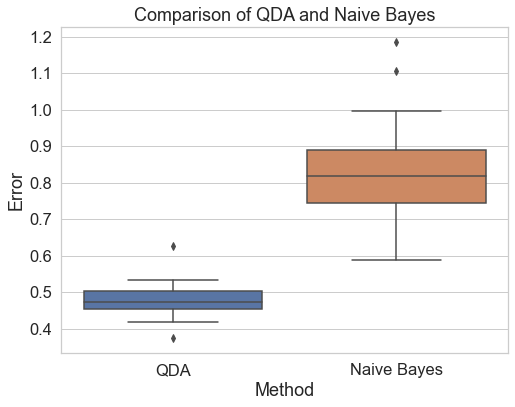

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
ax = sns.boxplot(x="Method", y="Error", data=err)
ax.set(xlabel='Method', ylabel='Error', title='Comparison of QDA and Naive Bayes')
plt.show()

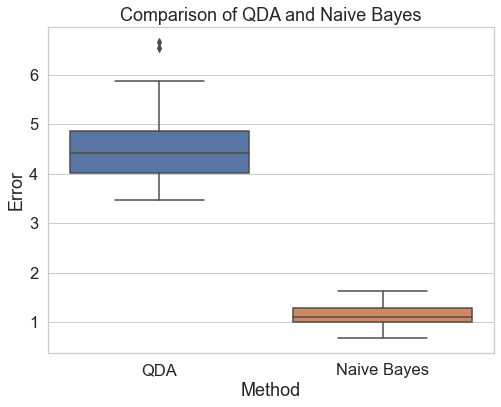

In [7]:
np.random.seed(20231024)

ntrain = 200
ntest = 500
n = ntrain + ntest
idx_train = np.arange(ntrain)
idx_test = np.arange(ntrain, n)

p = 50 # Number of predictors
beta = np.random.normal(size=p) # Coefficients

trial = 30 # Number of trials

Sig = 0.9**(np.abs(np.subtract.outer(np.arange(1,p+1), np.arange(1,p+1)))) # Covariance matrix, outer product function np.fill_diagonal(Sig, 1)

err = np.zeros((trial, 2)) # Error matrix

for i in range(trial):
    X = multivariate_normal(mean=np.zeros(p), cov=Sig).rvs(n)
    t = np.dot(X, beta)
    prob = 1 / (1 + np.exp(-t))
    y = np.random.binomial(1, prob, n)
    dat = pd.DataFrame(np.column_stack((X, y)), columns=[f"X{j}" for j in range(1,p+1)]+["y"])

    fit_qda = QuadraticDiscriminantAnalysis().fit(dat.iloc[idx_train,:-1], dat.iloc[idx_train,-1])
    pred_qda = fit_qda.predict_proba(dat.iloc[idx_test,:-1])
    err_qda = -np.sum(dat.iloc[idx_test,-1] * np.log(pred_qda[:,1]) + (1 - dat.iloc[idx_test,-1]) * np.log(pred_qda[:,0])) / ntest
    err[i, 0] = err_qda

    fit_nb = GaussianNB().fit(dat.iloc[idx_train,:-1], dat.iloc[idx_train,-1])
    pred_nb = fit_nb.predict_proba(dat.iloc[idx_test,:-1])
    err_nb = -np.sum(dat.iloc[idx_test,-1] * np.log(pred_nb[:,1]) + (1 - dat.iloc[idx_test,-1]) * np.log(pred_nb[:,0])) / ntest
    err[i, 1] = err_nb

err = pd.DataFrame(np.column_stack((np.arange(1,trial+1), err)), columns=["Trial", "QDA", "Naive Bayes"])
err = pd.melt( frame=err, id_vars="Trial", value_vars=["QDA", "Naive Bayes"], var_name="Method", value_name="Error" )

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
ax = sns.boxplot(x="Method", y="Error", data=err)
ax.set(xlabel='Method', ylabel='Error', title='Comparison of QDA and Naive Bayes')
plt.show()

Short summary of __bias-variance tradeoff__

- QDA performs well when the sample size is large.
- Naive Bayes can outperforms QDA with small sample size even with the violence of assumption.

Try to think about it!

## Cross-validation

In application, dividing the data into training and test sets may be a waste of information.
To fully use the whole dataset, we can apply the cross-validation strategy.

- Randomly partition the sample into $k$ equal-sized subsamples.
- Of the $k$ subsamples, a single subsample is retained as the validation data for testing the model, and the remaining $k − 1 $subsamples are used as training data.
- The cross-validation process is then repeated $k$ times, with each of the $k$ subsamples used exactly once as the validation data. 
- The $k$ results can then be averaged to produce a single estimation.
- All observations are used for both training and validation, and each observation is used for validation exactly once.
- 5 or 10 folds are usually used.

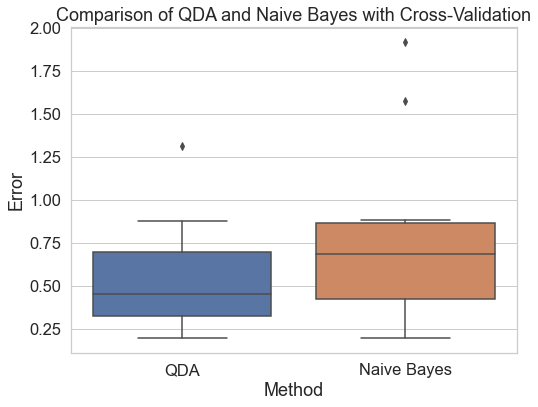

In [8]:
from sklearn.model_selection import KFold
np.random.seed(20231024)

n = 200 # Sample size
nfolds = 10 # Number of folds for cross-validation

p = 15 # Number of predictors
beta = np.random.normal(size=p) # Coefficients

Sig = 0.9**(np.abs(np.subtract.outer(np.arange(1,p+1), np.arange(1,p+1)))) # Covariance matrix, outer product function np.fill_diagonal(Sig, 1)

X = multivariate_normal(mean=np.zeros(p), cov=Sig).rvs(n)
t = np.dot(X, beta)
prob = 1 / (1 + np.exp(-t))
y = np.random.binomial(1, prob, n)
dat = pd.DataFrame(np.column_stack((X, y)), columns=[f"X{j}" for j in range(1,p+1)]+["y"])

dat_idx = np.random.choice(np.arange(n), n, replace=False)
cv_err = np.zeros((nfolds, 2))
kf = KFold(n_splits=nfolds)

for i, (train_idx, test_idx) in enumerate(kf.split(dat)):
    fit_qda = QuadraticDiscriminantAnalysis().fit(dat.iloc[train_idx,:-1], dat.iloc[train_idx,-1])
    pred_qda = fit_qda.predict_proba(dat.iloc[test_idx,:-1])
    err_qda = -np.sum(dat.iloc[test_idx,-1] * np.log(pred_qda[:,1]) + (1 - dat.iloc[test_idx,-1]) * np.log(pred_qda[:,0])) / (n / nfolds)
    cv_err[i, 0] = err_qda
    
    fit_nb = GaussianNB().fit(dat.iloc[train_idx,:-1], dat.iloc[train_idx,-1])
    pred_nb = fit_nb.predict_proba(dat.iloc[test_idx,:-1])
    err_nb = -np.sum(dat.iloc[test_idx,-1] * np.log(pred_nb[:,1]) + (1 - dat.iloc[test_idx,-1]) * np.log(pred_nb[:,0])) / (n / nfolds)
    cv_err[i, 1] = err_nb

cv_err = pd.DataFrame(np.column_stack((np.arange(1,nfolds+1), cv_err)), columns=["Fold", "QDA", "Naive Bayes"])
cv_err = pd.melt( frame=cv_err, id_vars="Fold", value_vars=["QDA", "Naive Bayes"], var_name="Method", value_name="Error" )

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
ax = sns.boxplot(x="Method", y="Error", data=cv_err)
ax.set(xlabel='Method', ylabel='Error', title='Comparison of QDA and Naive Bayes with Cross-Validation')
plt.show()

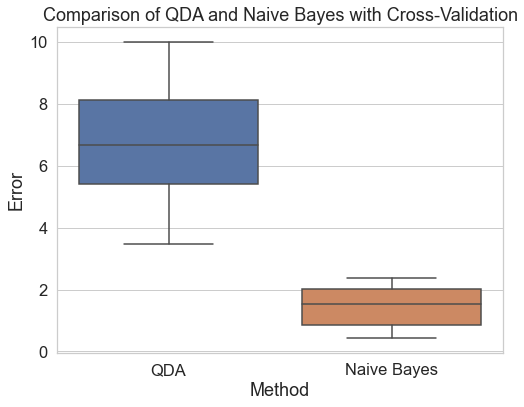

In [9]:
np.random.seed(20231024)

n = 200 # Sample size
nfolds = 10 # Number of folds for cross-validation

p = 50 # Number of predictors
beta = np.random.normal(size=p) # Coefficients

Sig = 0.9**(np.abs(np.subtract.outer(np.arange(1,p+1), np.arange(1,p+1)))) # Covariance matrix, outer product function np.fill_diagonal(Sig, 1)

X = multivariate_normal(mean=np.zeros(p), cov=Sig).rvs(n)
t = np.dot(X, beta)
prob = 1 / (1 + np.exp(-t))
y = np.random.binomial(1, prob, n)
dat = pd.DataFrame(np.column_stack((X, y)), columns=[f"X{j}" for j in range(1,p+1)]+["y"])

dat_idx = np.random.choice(np.arange(n), n, replace=False)
cv_err = np.zeros((nfolds, 2))
kf = KFold(n_splits=nfolds)

for i, (train_idx, test_idx) in enumerate(kf.split(dat)):
    fit_qda = QuadraticDiscriminantAnalysis().fit(dat.iloc[train_idx,:-1], dat.iloc[train_idx,-1])
    pred_qda = fit_qda.predict_proba(dat.iloc[test_idx,:-1])
    err_qda = -np.sum(dat.iloc[test_idx,-1] * np.log(pred_qda[:,1]) + (1 - dat.iloc[test_idx,-1]) * np.log(pred_qda[:,0])) / (n / nfolds)
    cv_err[i, 0] = err_qda
    
    fit_nb = GaussianNB().fit(dat.iloc[train_idx,:-1], dat.iloc[train_idx,-1])
    pred_nb = fit_nb.predict_proba(dat.iloc[test_idx,:-1])
    err_nb = -np.sum(dat.iloc[test_idx,-1] * np.log(pred_nb[:,1]) + (1 - dat.iloc[test_idx,-1]) * np.log(pred_nb[:,0])) / (n / nfolds)
    cv_err[i, 1] = err_nb

cv_err = pd.DataFrame(np.column_stack((np.arange(1,nfolds+1), cv_err)), columns=["Fold", "QDA", "Naive Bayes"])
cv_err = pd.melt( frame=cv_err, id_vars="Fold", value_vars=["QDA", "Naive Bayes"], var_name="Method", value_name="Error" )

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
ax = sns.boxplot(x="Method", y="Error", data=cv_err)
ax.set(xlabel='Method', ylabel='Error', title='Comparison of QDA and Naive Bayes with Cross-Validation')
plt.show()